In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd, numpy as np, re, time
import itertools
import seaborn as sns
sns.set(style = "whitegrid", color_codes = True,font_scale = 1.5)
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [162]:
df = pd.read_csv("train-balanced-sarcasm.csv")

# EDA

In [131]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [132]:
print("Number of Comments", len(df))

Number of Comments 1010826


In [133]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [134]:
print("Number of Sarcastic Comments", len(df.loc[df['label'] == 1]))
print("Number of Non-Sarcastic Comments", len(df.loc[df['label'] == 0]))

Number of Sarcastic Comments 505413
Number of Non-Sarcastic Comments 505413


Authors who commented the most?


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

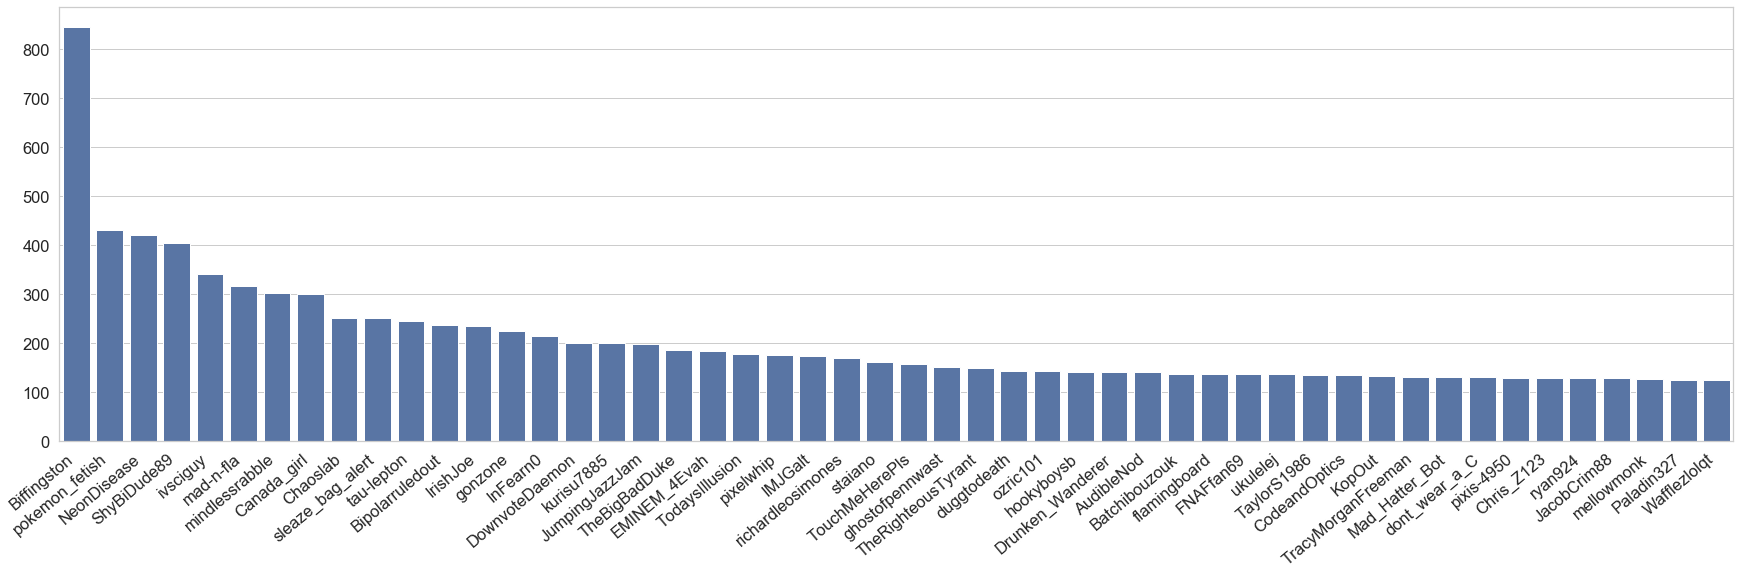

In [135]:
print("Authors who commented the most?")
plt.figure(figsize = (30,8))
star_count = df['author'].value_counts().sort_values(ascending=False)
sns.barplot(star_count.index[:50],star_count.values[:50],color='b')
plt.xticks(rotation=40,horizontalalignment='right')

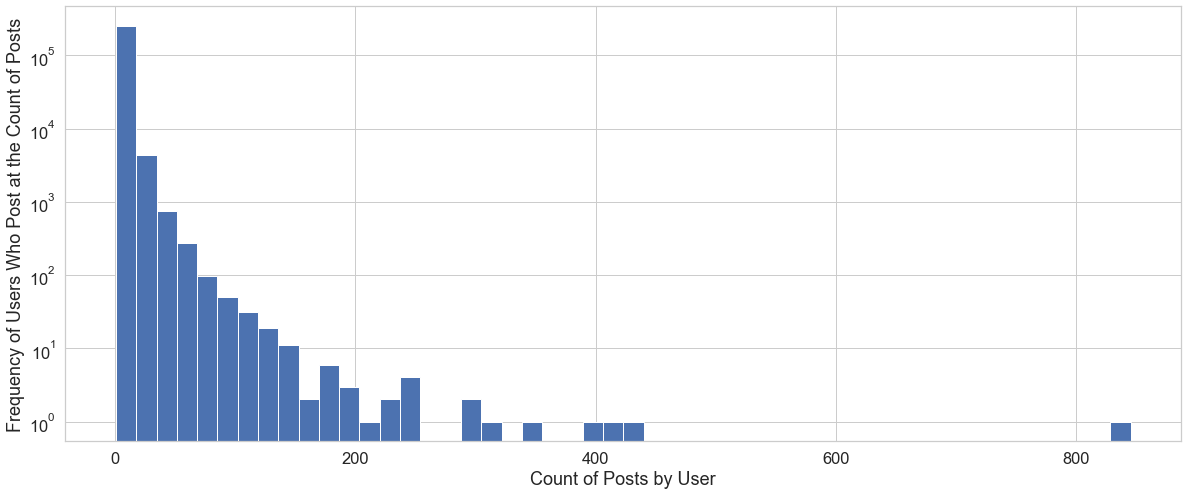

In [136]:
plt.figure(figsize = (20,8))
sns.distplot(star_count.values,kde=False,color='b', hist_kws=dict(alpha=1))
plt.yscale('log', nonposy='clip')
plt.xlabel("Count of Posts by User")
plt.ylabel("Frequency of Users Who Post at the Count of Posts")
plt.show()

**As we can see here, there is an outliar amongst the authors of the reddit posts. One redditor in particular (username "Biffingston") posts a disproportionate amount compared the others. However, since the number of comments is exponential in comparison to the rest of the users, it shouldn't have too much of an effect.**

# Subsetting the Data

In [226]:
df = pd.read_csv("train-balanced-sarcasm.csv")

In [227]:
sample_size = input()

20000


In [228]:
df = df.sample(int(sample_size))
df.reset_index(drop=True,inplace=True)

# Data Cleaning

In [229]:
df.dropna(axis = 0,how='any')

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,mysterious ways.,Thorbinator,atheism,3,3,0,2011-10,2011-10-24 03:20:34,"But more likely ""Atheists are evil, they kille..."
1,0,OH that makes sense.,RemberMyName,jailbreak,1,1,0,2015-08,2015-08-20 01:20:12,That person probably doesn't know that it does...
2,1,How did I know it was Jack Layton before I saw...,Flyspeck,canada,-4,-4,0,2011-04,2011-04-26 07:41:15,Look who I met today
3,0,Is everyone on this sub autistic?,WontDieIn_A_Hospital,LifeProTips,4,4,0,2016-03,2016-03-04 20:34:39,LPT: Ask dog owners before petting dogs in pub...
4,1,Looks like he's treating her like the queen sh...,otter6461a,niceguys,8,-1,-1,2016-10,2016-10-12 10:49:59,There's hope for nice guys after all...
5,0,"Very true, forgot about that.",stocky8,DarkNetMarkets,1,1,0,2014-11,2014-11-12 03:45:05,Wickr app has a feature to securely erase unus...
6,0,1 for 1...,PaulTheRedditor,AskReddit,12,12,0,2016-05,2016-05-26 16:25:35,He's been married a fuckload of times
7,1,Maybe they'll learn something.,jd4192367,AskReddit,-1,-1,0,2014-08,2014-08-12 06:18:20,It feels like this thread is full of 12 year o...
8,0,Sweet,marc120,witcher,1,1,0,2015-05,2015-05-15 20:35:53,It will not be limited to one reset per playth...
9,1,You dont have to apologize for your face being...,meermeermeer,herpetology,1,1,0,2012-06,2012-06-08 08:43:58,A lot of people enjoyed Professor X. I took hi...


In [230]:
print(len(df))

20000


In [231]:
print(df.isnull().any(axis = 0))

label             False
comment           False
author            False
subreddit         False
score             False
ups               False
downs             False
date              False
created_utc       False
parent_comment    False
dtype: bool


**The data above indicates that there are some null values amongst the comments. This would interfere with the analysis of the comments.**

## Figuring out the NaN float values which are causing issues

In [232]:
features = df['comment']
labels = df['label']
print(len(features))
print(len(labels))

20000
20000


In [233]:
start = time.time()

counter = 0
i_count = 0
bad_indices = []

for i,string in enumerate(features):
    try:
        if isinstance(string, float):
            counter += 1
            bad_indices.append(i_count)
    except:
        pass
    i_count += 1

print(counter)
print("i_count:", i_count)
print("bad_indices:", bad_indices)

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

0
i_count: 20000
bad_indices: []
0.029458045959472656 seconds


In [234]:
print(len(df))

20000


In [235]:
# Drop the rows that contain unusable values (float values in this case) 
for b in bad_indices:
    df = df.drop([b])
print(len(df))

20000


In [236]:
# df now has the dropped rows!
print(len(df))

20000


In [237]:
# New features!
features = df['comment']
labels = df['label']
print(len(features))
print(len(labels))

20000
20000


In [238]:
start = time.time()

counter = 0
i_count = 0
for i in df.itertuples():
    if not i[2]:
        counter += 1
        print(counter)
    i_count += 1

print(counter)
print("i_count", i_count)

end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

0
i_count 20000
0.07482481002807617 seconds


In [239]:
start = time.time()

In [240]:
# # Stemming data: reducing a word to its word stem
# ps = PorterStemmer()

# features = features.apply(lambda x: x.split())
# features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [241]:
end = time.time()
time_elapsed = end-start
print(time_elapsed, "seconds")

0.08802580833435059 seconds


In [242]:
#TF-IDF: Transoform text to meaningful numerical representation
tv = TfidfVectorizer(max_features = 5000)
# features = list(features)
features = tv.fit_transform(features).toarray()

In [243]:
# Training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

In [244]:
# Using linear support vector classifier
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
print(lsvc.score(features_train, labels_train))
print(lsvc.score(features_test, labels_test))

0.7834736842105263
0.617


In [245]:
# Using Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))
print(gnb.score(features_test, labels_test))

0.6818421052631579
0.522


In [246]:
# Using Logistic Regression
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7472105263157894
0.658


In [247]:
# Using Random Forest Classification
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))
print(rfc.score(features_test, labels_test)) 

0.9704736842105263
0.647
